In [1]:
# Plotar a série com CPs
import matplotlib.pyplot as plt
import numpy as np

def plot_series_with_cp(X, CP, CP_real=None, title=None, figsize=(10,4)):
    X = np.array(X)

    plt.figure(figsize=figsize)
    plt.plot(X, marker="o", ms=2, mfc='k', mec='k', linewidth=1, label='Série')

    # desenha linha para cada CP
    for cp in CP:
        plt.axvline(cp, color='red', linestyle='--', linewidth=2, label='CP VWCD')

    if CP_real is not None:
        for cp in CP_real:
            plt.axvline(cp, color='black', linestyle=':', linewidth=2, label='CP Real')

    if title is None:
        title = f"Série com {len(CP)} changepoints"
    plt.title(title)

    plt.xlabel("Índice")
    plt.xticks(range(0, len(X)+1, 5))
    plt.ylabel("Valor")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [2]:
# Plotar janelas
import numpy as np
import matplotlib.pyplot as plt

def plot_window(windows, starts, w, title=None, figsize=(10,4)):
    if isinstance(starts, int):
        starts = [starts]
    starts = list(starts)

    # validação simples
    for s in starts:
        if s < 0 or s + w - 1 >= max(len(windows) + w - 1, s + w):
            # não fazemos restrição rígida aqui porque windows pode não conter todos os starts
            pass

    # faixa global para o eixo x (desde o menor start até o maior end entre as janelas escolhidas)
    global_start = min(starts)
    global_end   = max(s + w - 1 for s in starts)
    x_global = np.arange(global_start, global_end + 1)

    plt.figure(figsize=figsize)
    cmap = plt.get_cmap("tab10")

    for k, s in enumerate(starts):
        # pega pos_valid para a janela que começa em s
        try:
            pw = np.asarray(windows[s], dtype=float)
        except Exception as e:
            raise IndexError(f"windows[{s}] não encontrado. Verifique que windows esteja indexado por start e tenha entry para {s}") from e

        # complementar para o tamanho w: [0] + pw + [0,0]
        # pw tem length = w-3 (segundo sua implementação), então full_pw terá length w
        full_pw = np.concatenate(([0.0, 0.0], pw, [0.0]))
        if full_pw.shape[0] != w:
            # proteção caso a suposição w-3 não se cumpra
            # redimensiona/trunca/expande conforme necessário
            if full_pw.shape[0] < w:
                pad = np.zeros(w - full_pw.shape[0])
                full_pw = np.concatenate((full_pw, pad))
            else:
                full_pw = full_pw[:w]

        # vetor alinhado ao eixo global
        aligned = np.full_like(x_global, np.nan, dtype=float)
        gstart = s - global_start
        gend   = s + w - 1 - global_start
        aligned[gstart:gend+1] = full_pw

        plt.plot(
            x_global,
            aligned,
            marker="o",
            ms=2,
            linestyle='-',
            label=f"Janela de {s} a {s+w-1}",
            color=cmap(k % 10)
        )

    plt.title(title or "Distribuições p(ν) das janelas")
    plt.xlabel("Índice da série")
    plt.ylabel("p(ν)")
    plt.xlim(global_start - 0.5, global_end + 0.5)
    plt.xticks(range(global_start, global_end + 1, 2))
    plt.grid(True, alpha=0.3)
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.tight_layout()
    plt.show()


In [3]:
# Função para plotar as probabilidades agregadas usando plt.stem
import matplotlib.pyplot as plt
import numpy as np
def plot_agg_probs(agg_probs, title=None, figsize=(10,4)):
    plt.figure(figsize=figsize)
    plt.stem(range(len(agg_probs)), agg_probs, basefmt=" ")
    plt.title(title or "Probabilidades Agregadas p(ν) ao longo da Série")
    plt.xlabel("Índice da série")
    plt.ylabel("P* Agregada")
    plt.xlim(-0.5, len(agg_probs) - 0.5)
    plt.xticks(range(0, len(agg_probs)+1, 5))
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [4]:
# Agregações e pesos
def pos_fun(ll, prior, tau):
    c = np.nanmax(ll)
    lse = c + np.log(np.nansum(prior * np.exp(ll - c)))
    p = ll[tau] + np.log(prior[tau]) - lse
    return np.exp(p)

def agg_linear(vote_list):
    vote_list = np.array(vote_list)
    p = vote_list.mean()
    # print(f"agg_linear: votes={vote_list}, p={p}")
    return p

def agg_multiplicativa(vote_list):
    vote_list = np.array(vote_list)
    prod1 = vote_list.prod()
    prod2 = (1 - vote_list).prod()
    p = prod1 / (prod1 + prod2)
    return p

def agg_logaritmica(vote_list, ws):
    vote_list = np.array(vote_list)
    prod1 = np.prod(vote_list ** ws)
    prod2 = np.prod((1 - vote_list) ** ws)
    p = prod1 / (prod1 + prod2)
    return p

def agg_otima(vote_list, ws, lamb):
    vote_list = np.array(vote_list)
    alfa = lamb / (1+lamb)
    prod1 = np.prod(vote_list ** (alfa * ws))
    prod2 = np.prod((1 - vote_list) ** (alfa * ws))
    p = prod1 / (prod1 + prod2)
    return p

def ws_H_exp(H_list):
    beta = 5
    ws_raw = np.exp(- beta * np.array(H_list))
    ws = ws_raw / ws_raw.sum()
    return ws

def ws_H(H_list):
    ws_raw = 1 / (np.array(H_list) + 1e-9)
    ws = ws_raw / ws_raw.sum()
    return ws

In [5]:
# VWCD
import numpy as np
from scipy.stats import betabinom
import time

def vwcd(X, w, vote_p_thr, ab=2, aggreg=agg_linear, pesos=None, lamb=None, verbose=False):
    def loglik(x, loc, scale):
        n = len(x)
        c = 1 / np.sqrt(2 * np.pi)
        y = n * np.log(c / scale) - (1 / (2 * scale**2)) * ((x - loc) ** 2).sum()
        return y

    N = len(X)
    i_ = np.arange(0, w - 3)
    prior_w = betabinom.pmf(i_, n=w - 4, a=ab, b=ab)

    votes = {i: [] for i in range(N)}
    entropies = {i: [] for i in range(N)}
    lcp = 0
    CP = []
    windows = [] # Armazena votos de cada janela
    
    vote_counts = np.zeros(N)      # Array para armazenar o número de votos
    agg_probs = np.zeros(N)        # Array para armazenar probabilidades agregadas

    startTime = time.time()
    for n in range(w - 1, N):
        Xw = X[n - w + 1 : n + 1]
        LLR_h = []
        min_std = 1e-9

        for nu in range(2, w - 1):
            # Hipótese HA
            x1 = Xw[:nu]
            m1 = x1.mean()
            s1 = x1.std(ddof=1)
            s1 = max(s1, min_std)
            logL1 = loglik(x1, loc=m1, scale=s1)
            x2 = Xw[nu:]
            m2 = x2.mean()
            s2 = x2.std(ddof=1)
            s2 = max(s2, min_std)
            logL2 = loglik(x2, loc=m2, scale=s2)

            # Cálculo do LLR
            llr = logL1 + logL2
            LLR_h.append(llr)

        LLR_h = np.array(LLR_h)
        pos = [pos_fun(LLR_h, prior_w, nu) for nu in range(w - 3)]
        pos = [np.nan] * 2 + pos + [np.nan]
        pos = np.array(pos)
        
        pos_valid = pos[~np.isnan(pos)]
        windows.append(pos_valid.copy()) 
        pos_safe = np.clip(pos_valid, 1e-10, 1.0)
        H_janela = -np.sum(pos_safe * np.log(pos_safe))

        for nu in range(2, w - 1):
            p_vote_h = pos[nu]
            j = n - w + 1 + nu
            votes[j].append(p_vote_h)
            entropies[j].append(H_janela)
            vote_counts[j] += 1

        votes_list = votes[n - w + 1]
        H_list = entropies[n - w + 1]
        num_votes = len(votes_list)

        if num_votes > 0:
            if pesos is not None:
                ws = pesos(H_list)
                if lamb is not None:
                    agg_vote = agg_otima(votes_list, ws, lamb)
                else:
                    agg_vote = aggreg(votes_list, ws)
            else:
                agg_vote = aggreg(votes_list)
        else:
            agg_vote = 0.0

        agg_probs[n - w + 1] = agg_vote

        if agg_vote > vote_p_thr:
            if verbose:
                print(f'Changepoint at n={n-w+1}, p={agg_vote}, n={num_votes} votes')
            lcp = n - w + 1
            CP.append(lcp)

    endTime = time.time()
    elapsedTime = endTime - startTime
    return CP, elapsedTime, vote_counts, agg_probs, votes, windows

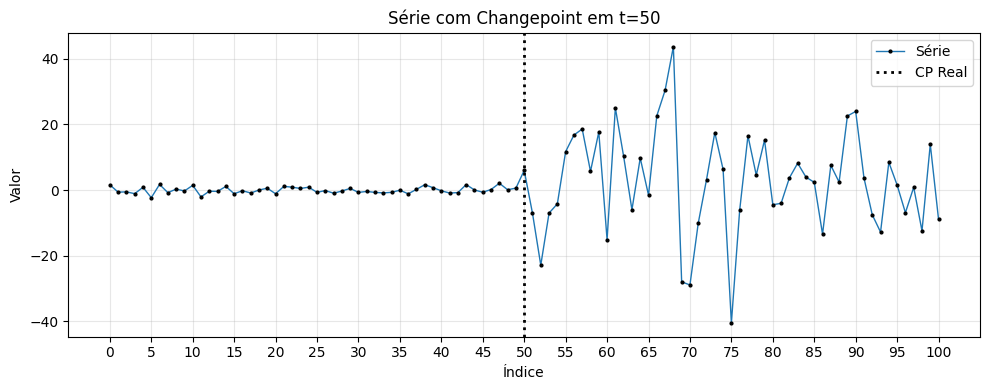

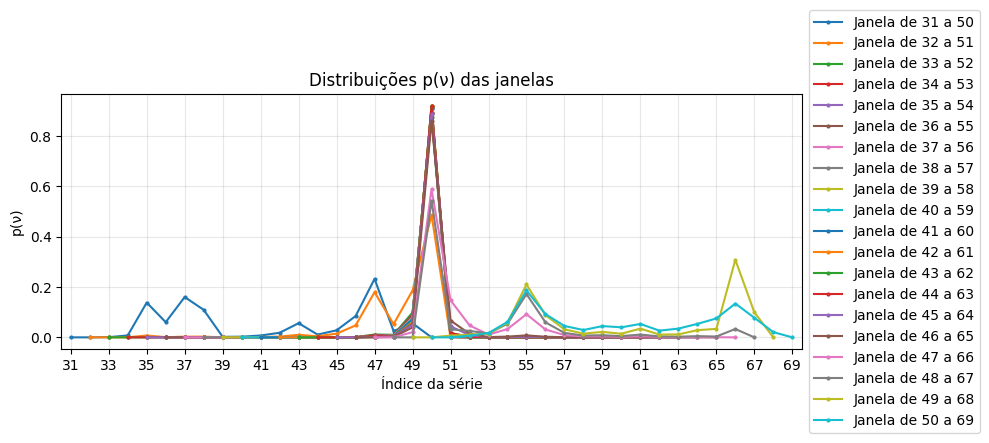

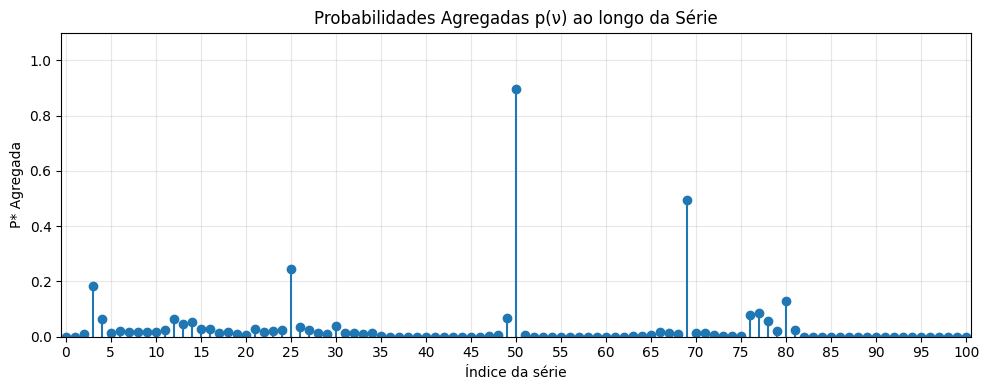

In [ ]:
from ArtificialTSGenerator import generate_series_fixed_cp, plot_series

np.random.seed(10) # Resultado bom mesmo pra media 1.2
# np.random.seed(1) # Usado na variação das médias e do desvio padrão
N = 101
cp_real = 50
means = [0, 0]
stds = [1, 20]
X, y  = generate_series_fixed_cp(N, means, stds, cp_real)
# state_labels = ["$f_0$" if state == 0 else "$f_B$" for state in y]
# plot_series(X, y, states_labels=state_labels, figsize=(10, 4), title=f"Série Temporal Sintética com Changepoint em t={t}")

w = 20
vote_p_thr = 0.7
ab = 2
l = 1

CP, elapsedTime, vote_counts, agg_probs, votes, windows = vwcd(X, w=w, vote_p_thr=vote_p_thr, ab=ab, aggreg=agg_logaritmica, pesos=ws_H, lamb=None, verbose=False)
                                                                        
CP = []
plot_series_with_cp(X, CP, CP_real=[cp_real], title=f"Série com Changepoint em t={cp_real}")


idxs = range(cp_real - w + 1, cp_real + 1)
plot_window(windows, idxs, w=w)
# plot_window(windows, cp_real-10+1, w=w)
plot_agg_probs(agg_probs, title="Probabilidades Agregadas Recalculadas")

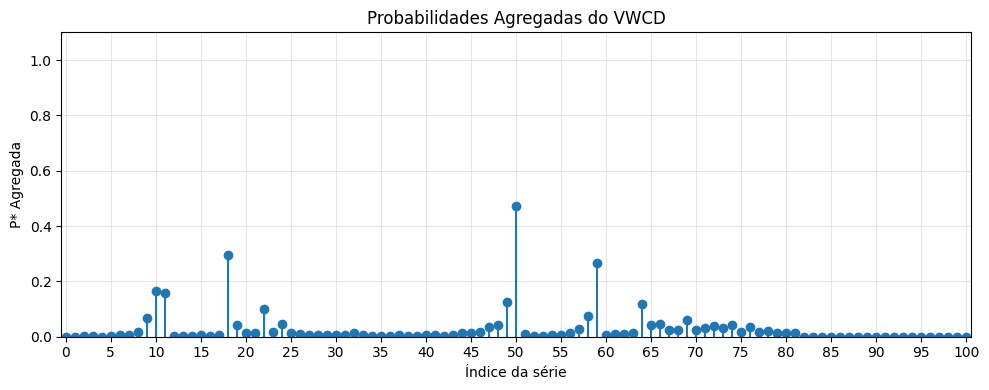

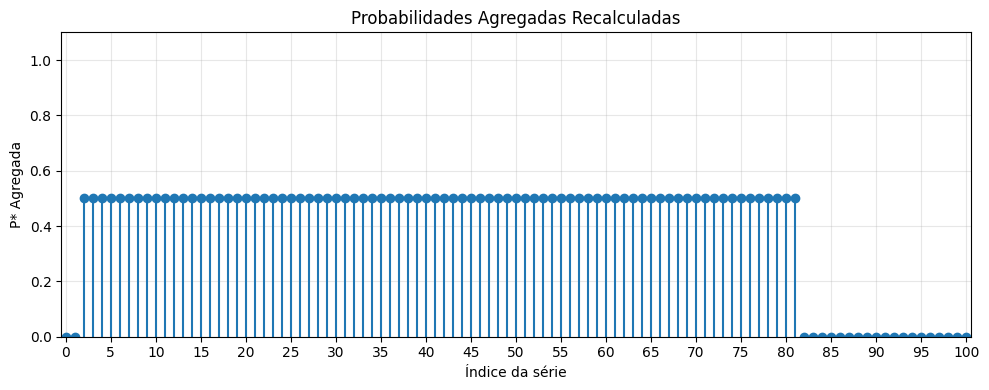

In [7]:
agg_probs_calc = np.zeros(len(votes))
N = len(votes)

for j in range(N-w+1):  # j é o ponto absoluto
    vote_list = votes[j]

    if len(vote_list) == 0:
        agg_probs_calc[j] = 0.0
        continue

    # janelas que contribuem para o ponto j:
    k_start = max(w - 1, j + 1)
    k_end   = min(N - 1, j + w - 3)

    H_list = []
    for k in range(k_start, k_end + 1):
        janela = windows[k - (w - 1)]  # porque windows[0] corresponde a n = w-1
        pos_safe = np.clip(janela, 1e-10, 1.0)
        H_janela = -np.sum(pos_safe * np.log(pos_safe))
        H_list.append(H_janela)

    ws = ws_H(H_list)
    agg_probs_calc[j] = agg_otima(vote_list, ws, lamb=0)

plot_agg_probs(agg_probs, title="Probabilidades Agregadas do VWCD")
plot_agg_probs(agg_probs_calc, title="Probabilidades Agregadas Recalculadas")